In [ ]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive/')
# drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [ ]:
data_dir = '/content/drive/My Drive/Fake_Face'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.




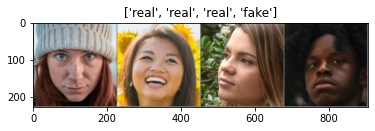

In [ ]:
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8401 Acc: 0.5600
val Loss: 1.1396 Acc: 0.5156

Epoch 1/24
----------
train Loss: 0.7422 Acc: 0.6506
val Loss: 1.1437 Acc: 0.5469

Epoch 2/24
----------
train Loss: 0.5529 Acc: 0.7331
val Loss: 0.8147 Acc: 0.6250

Epoch 3/24
----------
train Loss: 0.5137 Acc: 0.7906
val Loss: 0.7462 Acc: 0.7000

Epoch 4/24
----------
train Loss: 0.4294 Acc: 0.8194
val Loss: 0.9165 Acc: 0.7313

Epoch 5/24
----------
train Loss: 0.4095 Acc: 0.8169
val Loss: 0.8597 Acc: 0.6875

Epoch 6/24
----------
train Loss: 0.2355 Acc: 0.9062
val Loss: 0.7380 Acc: 0.7094

Epoch 7/24
----------
train Loss: 0.1399 Acc: 0.9531
val Loss: 0.6215 Acc: 0.7156

Epoch 8/24
----------
train Loss: 0.0979 Acc: 0.9675
val Loss: 0.6601 Acc: 0.7500

Epoch 9/24
----------
train Loss: 0.0848 Acc: 0.9781
val Loss: 0.6706 Acc: 0.7469

Epoch 10/24
----------
train Loss: 0.0592 Acc: 0.9850
val Loss: 0.6495 Acc: 0.7438

Epoch 11/24
----------
train Loss: 0.0464 Acc: 0.9881
val Loss: 0.6781 Acc: 0.7594

Ep

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model

torch.save(model_ft, '/content/drive/My Drive/Fake_Face/FakeFaceDiagnosis.h5')

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
model = torch.load('/content/drive/My Drive/Fake_Face/FakeFaceDiagnosis.h5')
# model.eval()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision import models
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# feature_extractor = models.vgg16(pretrained=True).features
# classifier = models.vgg16(pretrained=True).classifier

normalize = transforms.Normalize(
    mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5])

mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])


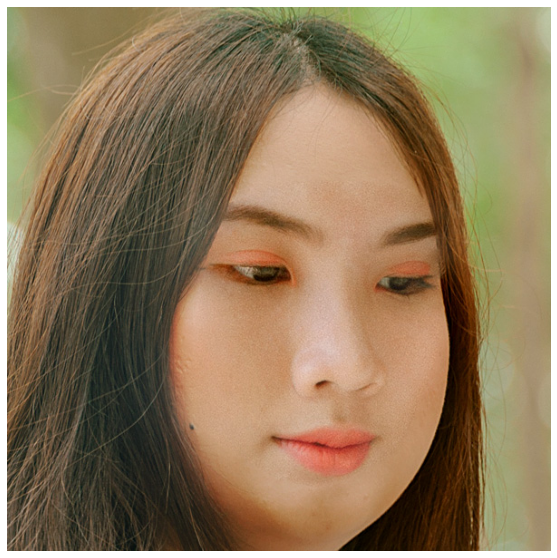

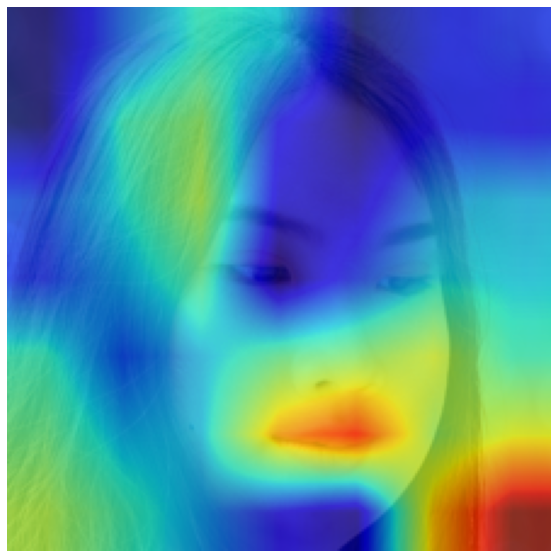

In [32]:
img = Image.open('/content/drive/My Drive/Fake_Face/Dataset/train/fake/easy_100_1111.jpg')
img_tensor = preprocess(img)
img


# img = img.convert('RGB').resize((224, 224))
# img = tf.to_tensor(img) # [3, 224, 224]
# img = tf.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

feature = feature_extractor(img_tensor.view(-1,3,224,224))
feature = feature.clone().detach().requires_grad_(True)
y_pred = classifier(feature.view(-1,512*7*7))
y_pred[0][torch.argmax(y_pred)].backward()
alpha = torch.mean(feature.grad.view(512,7*7),1)
feature = feature.view(512,7,7)
L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu().detach().numpy()
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = toHeatmap(cv2.resize(L,(224,224)))

img1 = (img_tensor*std + mean).permute(1,2,0).cpu().detach().numpy()
img2 = L

alpha = 0.3
blended = img1*alpha + img2*(1-alpha)

plt.figure(figsize=(10,10))
plt.imshow(blended)
plt.axis('off')
plt.show()

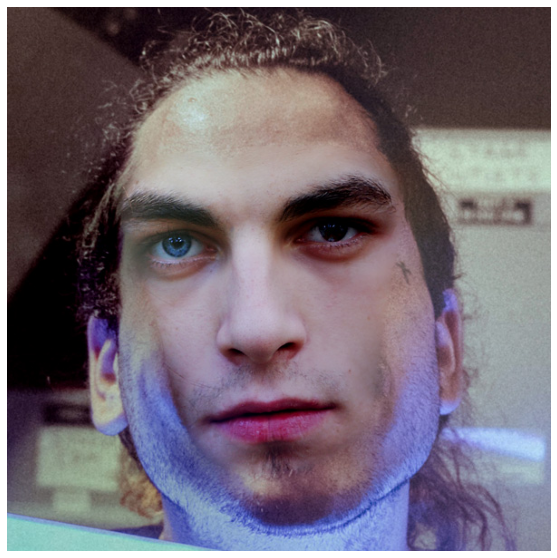

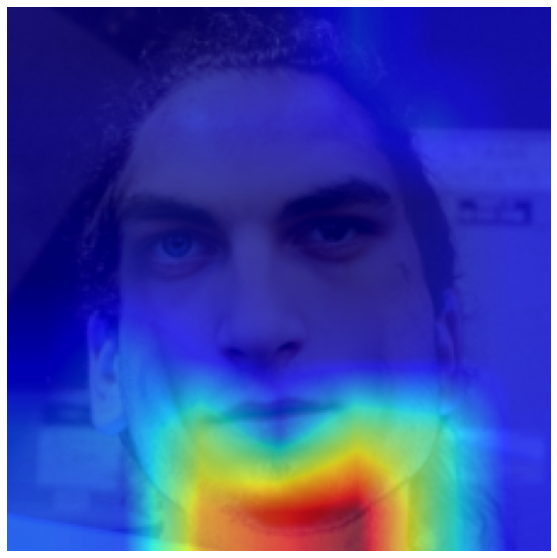

In [31]:
img = Image.open('/content/drive/My Drive/Fake_Face/Dataset/train/fake/easy_11_1111.jpg')
img_tensor = preprocess(img)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

feature = feature_extractor(img_tensor.view(-1,3,224,224))
feature = feature.clone().detach().requires_grad_(True)
y_pred = classifier(feature.view(-1,512*7*7))
y_pred[0][torch.argmax(y_pred)].backward()
alpha = torch.mean(feature.grad.view(512,7*7),1)
feature = feature.view(512,7,7)
L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu().detach().numpy()
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = toHeatmap(cv2.resize(L,(224,224)))

img1 = (img_tensor*std + mean).permute(1,2,0).cpu().detach().numpy()
img2 = L

alpha = 0.3
blended = img1*alpha + img2*(1-alpha)

plt.figure(figsize=(10,10))
plt.imshow(blended)
plt.axis('off')
plt.show()

In [ ]:
img = Image.open('/content/drive/My Drive/Fake_Face/Dataset/train/fake/easy_11_1111.jpg')
img_tensor = preprocess(img)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

feature = feature_extractor(img_tensor.view(-1,3,224,224))
feature = feature.clone().detach().requires_grad_(True)
y_pred = classifier(feature.view(-1,512*7*7))
y_pred[0][torch.argmax(y_pred)].backward()
alpha = torch.mean(feature.grad.view(512,7*7),1)
feature = feature.view(512,7,7)
L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu().detach().numpy()
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = toHeatmap(cv2.resize(L,(224,224)))

img1 = (img_tensor*std + mean).permute(1,2,0).cpu().detach().numpy()
img2 = L

alpha = 0.3
blended = img1*alpha + img2*(1-alpha)

plt.figure(figsize=(10,10))
plt.imshow(blended)
plt.axis('off')
plt.show()

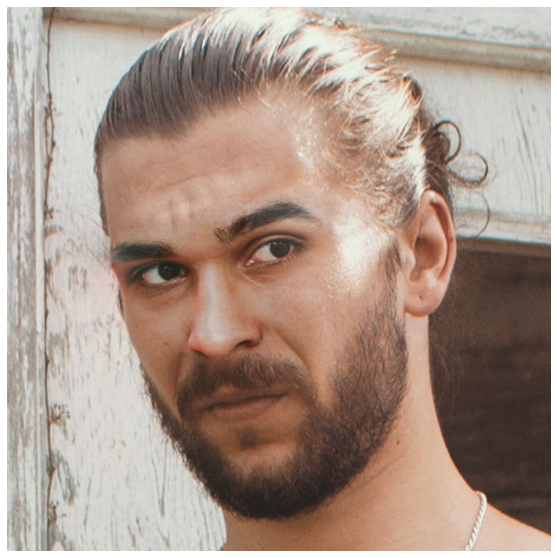

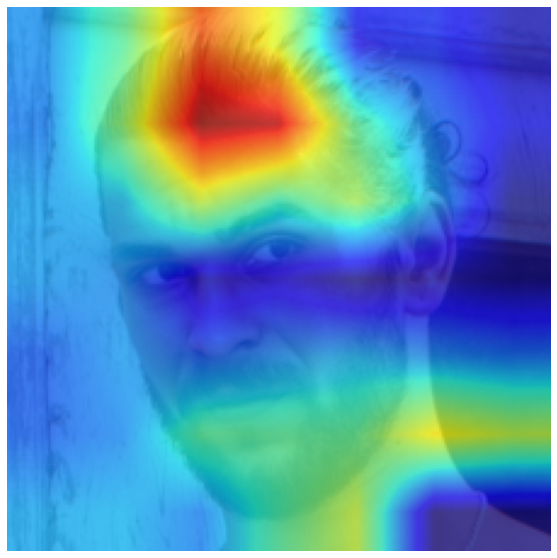

In [34]:
img = Image.open('/content/drive/My Drive/Fake_Face/Dataset/train/fake/hard_166_1110.jpg')
img_tensor = preprocess(img)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(224,224,3)

feature = feature_extractor(img_tensor.view(-1,3,224,224))
feature = feature.clone().detach().requires_grad_(True)
y_pred = classifier(feature.view(-1,512*7*7))
y_pred[0][torch.argmax(y_pred)].backward()
alpha = torch.mean(feature.grad.view(512,7*7),1)
feature = feature.view(512,7,7)
L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu().detach().numpy()
L_min = np.min(L)
L_max = np.max(L - L_min)
L = (L - L_min)/L_max

L = toHeatmap(cv2.resize(L,(224,224)))

img1 = (img_tensor*std + mean).permute(1,2,0).cpu().detach().numpy()
img2 = L

alpha = 0.3
blended = img1*alpha + img2*(1-alpha)

plt.figure(figsize=(10,10))
plt.imshow(blended)
plt.axis('off')
plt.show()